In [1]:
import openfst_python as fst
from subprocess import check_call
from IPython.display import Image
from helper_functions import *

In [10]:
lex_dict = {'speak':[['s','p','ee','k']],
            'speech': [['s','p','ee','ch']],
            'spell': [['s','p','eh','l']],
            'say': [['s','ey']],
            'the':[['dh','ih'],['dh','ah']]
           }

In [42]:
class TrieNode: 
      
    # Trie node class 
    def __init__(self, phone, state): 
        self.children = []
        self.phone = phone
        self.state = state
        
    def add_child(self, trie_node):
        self.children.append(trie_node)
        
    def __eq__(self, val):
        return (val == self.phone)
    
    def __repr__(self):
        return self.phone


class Trie:
    
    def __init__(self, lex, original=True):
        
        self.lex = parse_lexicon(lex,False)
        self.word_table, self.phone_table, self.state_table = generate_symbols_table(self.lex,1)
        self.output_table = generate_output_table(self.word_table, self.phone_table)
        
        print(f"phone table: {list(self.phone_table)}")
        print(f"Output stable: {list(self.output_table)}")
        
        self.f = fst.Fst()
        
        start_state = self.f.add_state()
        self.f.set_start(start_state)
        self.root = self.getNode('', start_state) 
        
        for word in self.lex:
#             print(f"Word: {word}, phones: {self.lex[word]}")
            self.insert(word)
            
        self.f.set_input_symbols(self.state_table)
        self.f.set_output_symbols(self.output_table)
  
    def getNode(self, phone, state): 
        # Returns new trie node (initialized to NULLs) 
        return TrieNode(phone, state) 
    
    
    def insert(self,word):
        current_node = self.root
        for phones in self.lex[word]:
            current_phone = phones[0]
            self._insert(word, current_node, current_phone, phones, 0)
    
    def _insert(self, word, node, phone, phones, phone_idx):
        # check if the current node is this phone
        found = False
#         phones = self.lex[word]
#         print(f"Checking node {node}, with phone {phone}")
        for child_node in node.children: 
            if (child_node.phone == phone):
                found = True
                if (phone_idx == len(phones) - 1):
#                     self.f.set_final(node.state)
                    return child_node
                else:
                    next_phone = phones[phone_idx + 1]
#                     print(f"checking Node {child_node} to node {node}")
                    next_node = self._insert(word, child_node, next_phone, phones, phone_idx + 1)
#                     self.f.add_arc(node.state, fst.Arc(0, self.output_table.find(phone), None, next_node.state))
                    
                    
                
        # create the new phone node
        if (found == False):
#             print(f"Phone {phone} not a child of this node {node}, so adding..")
            new_state = self.f.add_state()
            new_node = self.getNode(phone, new_state)
            node.add_child(new_node)
#             print(f"State {new_state} is phone {phone}")
            # if this is last phone then return
            if (phone_idx == (len(phones) -1)):
                self.f.set_final(new_node.state)
                return new_node
            else:
                next_phone = phones[phone_idx + 1]
#                 print(f"-- Adding Node {new_node} to node {node}")
                next_node = self._insert(word, new_node, next_phone, phones, phone_idx + 1)
#                 print(f"Adding arc between state {node.state} and next state {next_node.state}")
#                 self.f.add_arc(node.state, fst.Arc(0, self.output_table.find(phone), None, next_node.state))
        
#         return node
    
    def create_arcs(self):
        node = self.root
        self._create_arcs(node)
    
    def _create_arcs(self, node):
        for child_node in node.children:
            next_node = self._create_arcs(child_node) 
            self.f.add_arc(node.state, fst.Arc(0, self.output_table.find(next_node.phone), None, next_node.state))
        return node
    
    def __repr__(self):
        node = self.root
        string = f"{node}"
        string = self._toString(string, node)
        return string
        
    def _toString(self, string, node):
        string = f"{string} + {node.phone}"
        for child_node in node.children:
            string += self._toString(string, child_node)
        return string

In [43]:
trie = Trie('lexicon.txt')
trie.create_arcs()

phone table: [(0, '<eps>'), (1, 'ah'), (2, 'ey'), (3, 'v'), (4, 'p'), (5, 'eh'), (6, 'k'), (7, 'er'), (8, 'z'), (9, 'iy'), (10, 't'), (11, 'ih'), (12, 'l'), (13, 'd'), (14, 'ay'), (15, 'dh'), (16, 'w'), (17, 'r')]
Output stable: [(0, '<eps>'), (1, 'ah'), (2, 'ey'), (3, 'v'), (4, 'p'), (5, 'eh'), (6, 'k'), (7, 'er'), (8, 'z'), (9, 'iy'), (10, 't'), (11, 'ih'), (12, 'l'), (13, 'd'), (14, 'ay'), (15, 'dh'), (16, 'w'), (17, 'r'), (18, 'a'), (19, 'of'), (20, 'peck'), (21, 'peppers'), (22, 'peter'), (23, 'picked'), (24, 'pickled'), (25, 'piper'), (26, 'the'), (27, "where's")]


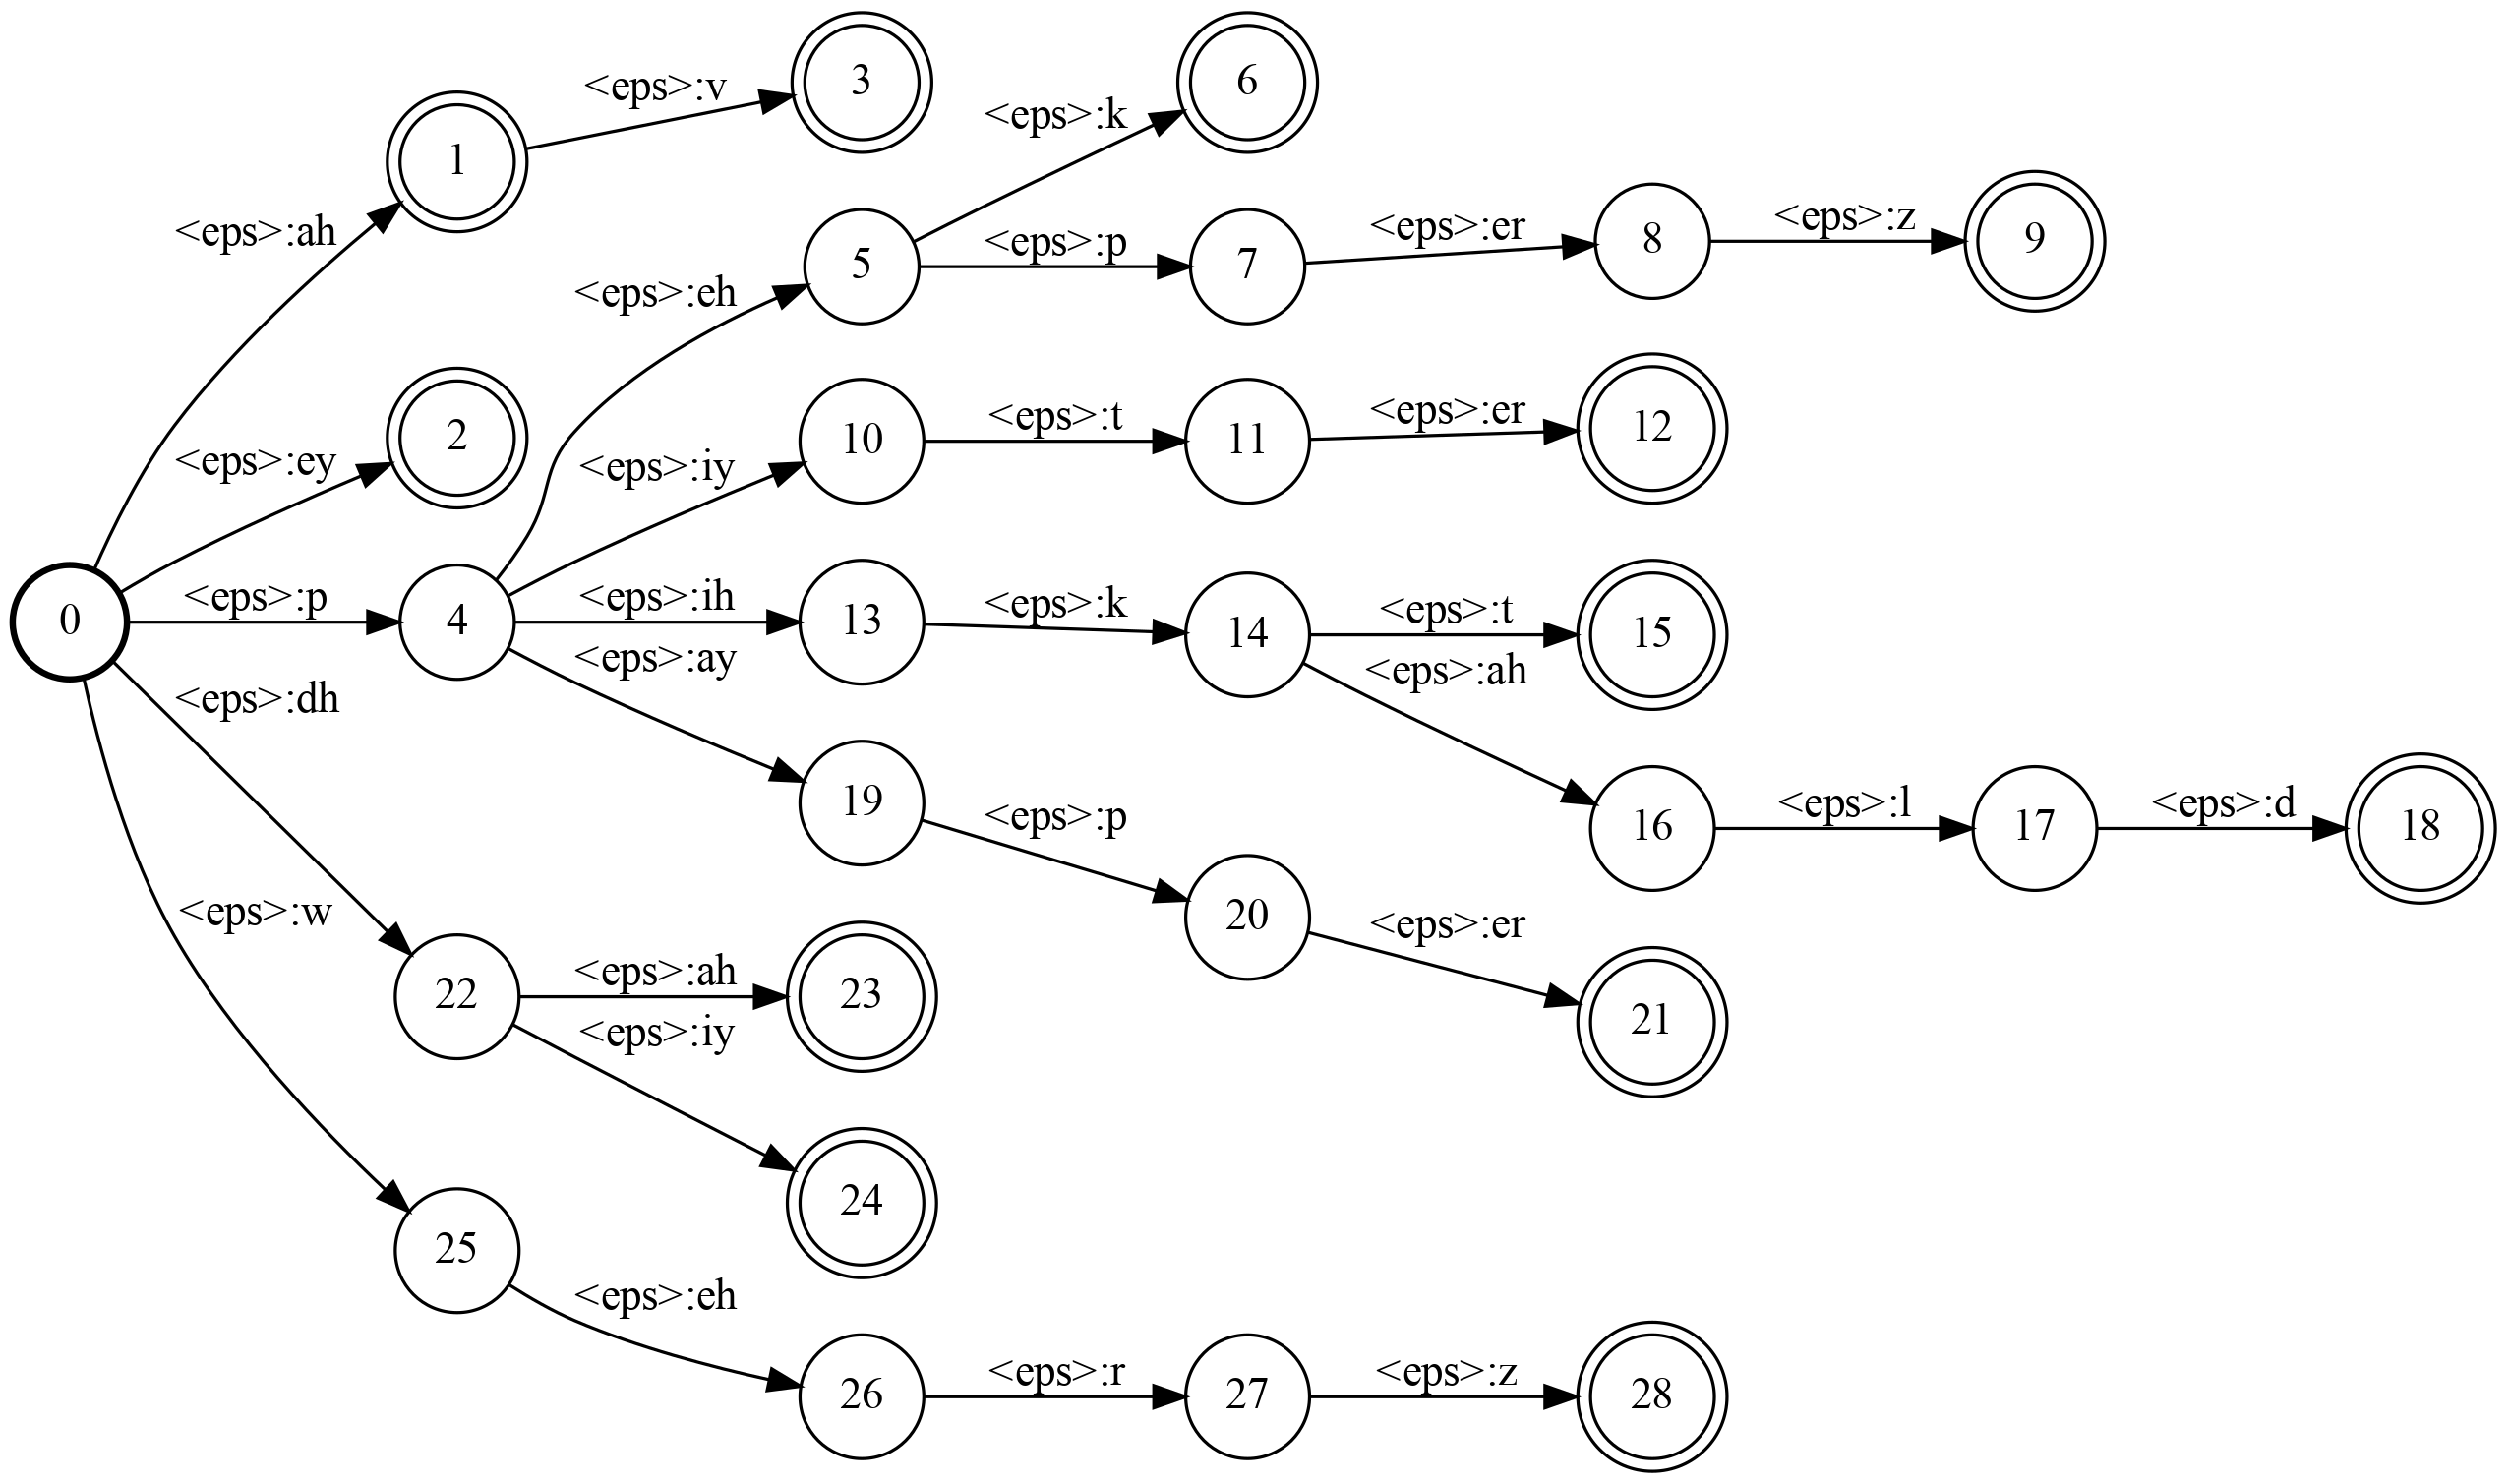

In [37]:
trie.f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=300','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [59]:
class TrieNode: 
      
    # Trie node class 
    def __init__(self, phone): 
        self.children = []
        self.phone = phone
        
    def add_child(self, trie_node):
        self.children.append(trie_node)
        
    def __eq__(self, val):
        return (val == self.phone)
    
    def __repr__(self):
        return self.phone
    
    def repr(self, depth=0):
#         depth = 1
        node = self
        string = []
        for idx, i in enumerate(node.children):
            string.append("{}{} {}".format(' ' * depth,self.phone or '#','\n' + node.children[idx].repr(depth=depth + 1)))
        return ''.join(string)
        
    
class Trie:
    
    def __init__(self, lex):
        self.root = self.getNode('') 
        self.lex = lex
        
        for word in self.lex:
            self.insert(word)
  
    def getNode(self, phone): 
      
        # Returns new trie node (initialized to NULLs) 
        return TrieNode(phone) 
    
    
    def insert(self,word):
        current_node = self.root
        current_phone = self.lex[word][0]
        self._insert(word, current_node, current_phone)
    
    def _insert(self, word, node, phone):
        # check if the current node is this phone
        found = False
        phones = self.lex[word]
        
        for child_node in node.children: 
            if (child_node.phone == phone):
                found = True
                if (phone == phones[-1]):
                    return # last phones
                else:
                    next_phone = phones[phones.index(phone) + 1]
                    self._insert(word, child_node, next_phone)
                
        # create the new phone node
        if (found == False):
            new_node = self.getNode(phone)
            node.add_child(new_node)
            
            # if this is last phone then return
            if (phone == phones[-1]):
                return 
            else:
                next_phone = phones[phones.index(phone) + 1]
                self._insert(word, new_node, next_phone)

    def repr(self, depth=0):
#         depth = 1
        node = self.root
        string = []
        for idx, i in enumerate(node.children):
            string.append("{}{} {}".format(' ' * depth,i.phone or '#','\n' + node.children[idx].repr(depth=depth + 1)))
        return ''.join(string)
        
        
#         string = f"{node}"
#         string = self._toString(string, node)
        return string
        
    def _toString(self, string, node):
        string = f"{string} + {node.phone}"
        for child_node in node.children:
            string += self._toString(string, child_node)
        return string
                
        

In [60]:
test = Trie(lex_dict)

In [57]:
print(test.repr())

s 
 s 
  p 
   ee 
   ee 

